<a href="https://colab.research.google.com/github/SohamPatel46/Image_Classification/blob/main/Cat_Vs_Dog_Custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

In this Notebook, You'll follow these steps:

1.   Explore the Example Data of Cats and Dogs
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-10-11 05:18:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   120MB/s    in 0.5s    

2020-10-11 05:18:18 (120 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [ ]:
import os
import zipfile
 
local_zip = '/tmp/cats_and_dogs_filtered.zip'
 
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets, which in turn each contain `cats` and `dogs` subdirectories.


The training set is the data that is used to tell the neural network model that 'this is what a cat looks like', 'this is what a dog looks like' etc. 

The validation data set is images of cats and dogs that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a cat or a dog.

Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
 
# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
 
# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
 
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.162.jpg', 'cat.307.jpg', 'cat.223.jpg', 'cat.815.jpg', 'cat.660.jpg', 'cat.600.jpg', 'cat.483.jpg', 'cat.165.jpg', 'cat.458.jpg', 'cat.553.jpg']
['dog.309.jpg', 'dog.423.jpg', 'dog.251.jpg', 'dog.570.jpg', 'dog.117.jpg', 'dog.538.jpg', 'dog.799.jpg', 'dog.786.jpg', 'dog.480.jpg', 'dog.739.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))
 
print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


For both cats and dogs, we have 1,000 training images and 500 validation images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline
 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
 
pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

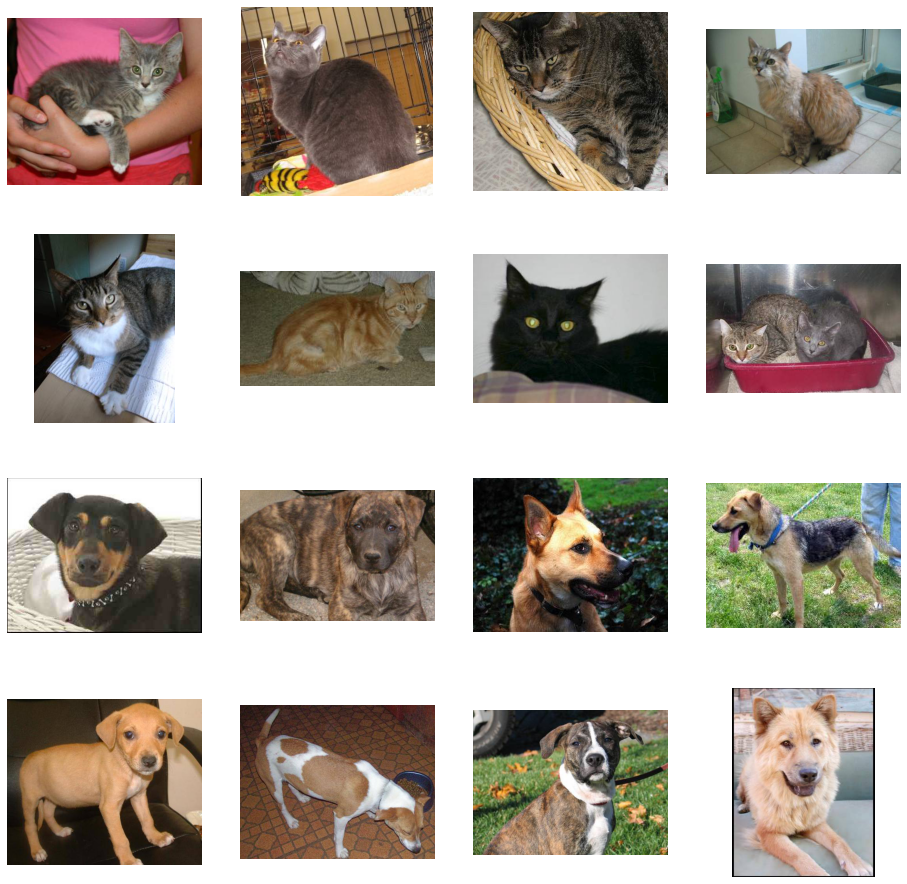

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
 
pic_index+=8
 
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]
 
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]
 
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
 
  img = mpimg.imread(img_path)
  plt.imshow(img)
 
plt.show()

Now that you have an idea for what your data looks like, the next step is to define the model that will be trained to recognize cats or dogs from these images 

## Building a Small Model from Scratch

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly. 

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [ ]:
import tensorflow as tf

Next we will define a Sequential layer, adding some convolutional layers and Pooling layers. 
Shape is 150x150x3 for the image. 


In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150 x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

The model.summary() method call prints a summary of the NN 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
 
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
 
# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 5 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course.


In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=5,
                    validation_steps=50,
                    verbose=2)

Epoch 1/5
100/100 - 8s - loss: 0.8331 - accuracy: 0.5515 - val_loss: 0.6656 - val_accuracy: 0.5350
Epoch 2/5
100/100 - 8s - loss: 0.6466 - accuracy: 0.6530 - val_loss: 0.6064 - val_accuracy: 0.6860
Epoch 3/5
100/100 - 8s - loss: 0.5497 - accuracy: 0.7325 - val_loss: 0.6162 - val_accuracy: 0.6590
Epoch 4/5
100/100 - 8s - loss: 0.4642 - accuracy: 0.7820 - val_loss: 0.9786 - val_accuracy: 0.6120
Epoch 5/5
100/100 - 8s - loss: 0.3630 - accuracy: 0.8410 - val_loss: 0.6384 - val_accuracy: 0.7260


###Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a dog or a cat.

In [ ]:
import numpy as np
 
from google.colab import files
from keras.preprocessing import image
 
uploaded=files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

Saving download (1).jpg to download (1).jpg
[0.]
download (1).jpg is a cat
